# Sparse processing with LiberTEM

This notebook demonstrates support for sparse data in LiberTEM, both the generation of sparse data from such formats, and the processing of these data using both sparse-compatible and -incompatible UDFs.

Additionally, the notebook demonstrates sparse-GPU-array support, which requires a working CUDA/CuPy installation to run correctly.

Some preliminaries:

In [1]:
%matplotlib inline
import pathlib
import tempfile

In [2]:
# Write files in a temporary directory
# Not guaranteed to be cleaned up in a Notebook in *all* circumstances
td = tempfile.TemporaryDirectory()
workdir = pathlib.Path(td.name)

## Create some example data

For our sparse input data we'll mock some diffraction data of the type you might acquire with a direct electron camera (low count, many zeros):

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.draw as skdraw

nav_shape = (8, 32)
sig_shape = (64, 64)
# For a bit of interest we will mock a quantum well-like structure
# with a different brightfield intensity and a beam shift
qw_region = (14, 19)
radius = 8
qw_shift = {qw_region[0]: (0, -1), qw_region[1] - 1: (0, 1)}

In [4]:
def get_diff_frame(dim, radius, shift_yx=(0, 0), intensity=3, bkg_sparsity=0.9):
    """Return a single diffraction spot with Poisson-esque noise characteristics"""
    bkg = np.random.poisson(lam=1, size=(dim, dim))
    bkg_mask = np.random.choice([0, 1], p=(bkg_sparsity, 1-bkg_sparsity), size=(dim, dim))
    disk = np.random.poisson(lam=intensity, size=(dim, dim))
    rr, cc = skdraw.disk((dim // 2 + shift_yx[0], dim // 2 + shift_yx[1]), int(radius))
    disk_mask = np.zeros((dim, dim))
    disk_mask[rr, cc] = 1
    return np.minimum(bkg * bkg_mask + disk * disk_mask, 255).astype(np.uint8)

Build the data cube frame-by-frame:

In [5]:
dense_data = np.zeros(nav_shape + sig_shape, dtype=np.uint8)

for y in range(nav_shape[0]):
    for x in range(nav_shape[1]):
        dense_data[y, x] = get_diff_frame(
            sig_shape[0],
            radius,
            shift_yx=qw_shift.get(x, (0, 0)),
            intensity=4 if x in range(*qw_region) else 3,
        )

Plot the first frame to see how it looks:

Text(0.5, 1.0, 'Example frame')

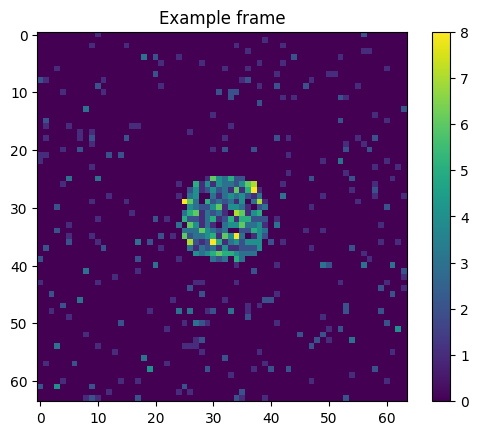

In [6]:
plt.imshow(dense_data[0, 0])
plt.colorbar()
plt.title('Example frame')

Here are some stats about this data:

In [7]:
# NBVAL_IGNORE_OUTPUT
print(f'Density: {np.count_nonzero(dense_data) / dense_data.size:.3f}')
print(f'Byte-size: {dense_data.size * dense_data.dtype.itemsize / 2**20} MB')

Density: 0.105
Byte-size: 1.0 MB


## Storage of raw sparse data on disk (CSR-format)

We can use `sparseconverter` to get a sparse representation of this data in Scipy CSR format. At time of writing, the data must be in the form of a 2D array, so we roll the `nav_shape` and `sig_shape` into two flat dimensions:

In [8]:
# NBVAL_IGNORE_OUTPUT
from sparseconverter import SCIPY_CSR, for_backend

# Convert to 2D for scipy.csr_matrix compatibility
data_2d = dense_data.reshape(np.prod(nav_shape), np.prod(sig_shape))
data_sparse = for_backend(data_2d, SCIPY_CSR)
data_sparse

<256x4096 sparse matrix of type '<class 'numpy.uint8'>'
	with 110507 stored elements in Compressed Sparse Row format>

`sparseconverter` provides a unified API for conversion between many sparse array formats in major Python libraries. For this part of the example we will use Scipy CSR as it supports a storage on disk in a raw format directly compatible with LiberTEM.

The format is composed of three binary files:

- `data`: containing the flattened, nonzero array values, available as `data_sparse.data`
- `indices`: containing column indices corresponding to values in `data`, available as `data_sparse.indices`
- `indptr`: containing the per-row slices into `data` and `indices`, available as `data_sparse.indptr`

(see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix for more information).

We can save these three arrays to disk for processing with LiberTEM's `RawCSRDataSet`:

In [9]:
data_sparse.data.tofile(workdir / 'values.raw')
data_sparse.indices.tofile(workdir / 'coords.raw')
data_sparse.indptr.tofile(workdir / 'indptr.raw')

The total size of data on disk is:

In [10]:
import os
print(f"Size on disk: {sum(os.path.getsize(workdir / f) for f in ('indptr.raw', 'coords.raw', 'values.raw')) / 2**20:.2f} MB")

Size on disk: 0.53 MB


which is not a huge saving compared to the dense form, but this will depend on the overall sparsity.

To allow LiberTEM to read the data, we also need to create a parameter file containing the metadata for the format, which tells the dataset where to find `indptr`, `coords` and `values`. Here we do this in the code, but normally this would be created in a text editor or by the software generating the data.

In [11]:
metadata = f"""
[params]
filetype = "raw_csr"
nav_shape = {list(nav_shape)}
sig_shape = {list(sig_shape)}

[raw_csr]
indptr_file = "indptr.raw"
indptr_dtype = "{str(data_sparse.indptr.dtype)}"

indices_file = "coords.raw"
indices_dtype = "{str(data_sparse.indices.dtype)}"

data_file = "values.raw"
data_dtype = "{str(data_sparse.data.dtype)}"
"""

param_file = workdir / 'sparse.toml'

with param_file.open('w') as f:
    f.write(metadata)

The format of the metadata file is TOML (https://toml.io/en/).

## Processing with LiberTEM - Standard analyses

First we load the dataset using the `raw_csr` format keyword and the path to our sparse CSR parameter file:

In [12]:
import libertem.api as lt

ctx = lt.Context.make_with('inline')
dataset_csr = ctx.load("raw_csr", path=param_file)

We can get a brightfield-like view of the data using a disk-sum analysis:

Text(0.5, 1.0, 'Brightfield (counts)')

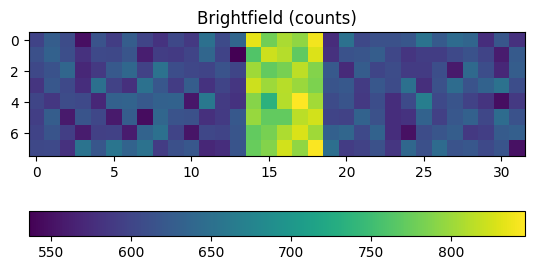

In [13]:
disk_a = ctx.create_disk_analysis(dataset_csr)
disk_r = ctx.run(disk_a)

plt.imshow(disk_r.intensity.raw_data)
plt.colorbar(orientation="horizontal")
plt.title('Brightfield (counts)')

The log-sum of all frames in the dataset:

Text(0.5, 1.0, 'Logsum frame')

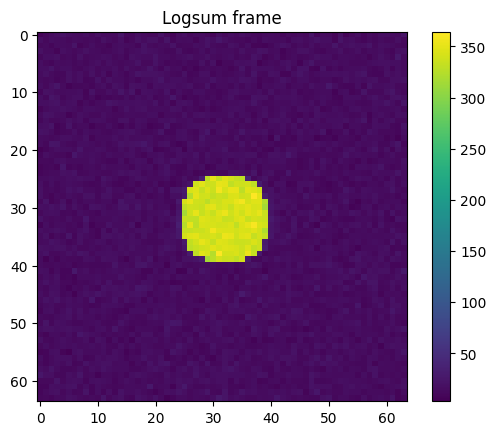

In [14]:
from libertem.udf.logsum import LogsumUDF
logsum_r = ctx.run_udf(dataset=dataset_csr, udf=LogsumUDF())

plt.imshow(logsum_r['logsum'].data)
plt.colorbar()
plt.title('Logsum frame')

And we can measure the shift of the central disk in the x-direction using a centre-of-mass analysis:

Text(0.5, 1.0, 'CoM-X-shift (px)')

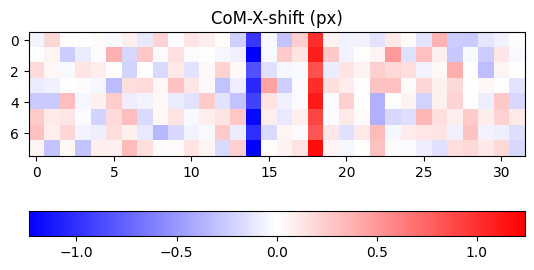

In [15]:
com_a = ctx.create_com_analysis(dataset_csr, cx=sig_shape[1] // 2, cy=sig_shape[0] // 2, mask_radius=radius * 1.2)
com_r = ctx.run(com_a)

from matplotlib.colors import CenteredNorm
plt.imshow(com_r.x.raw_data, cmap='bwr', norm=CenteredNorm())
plt.colorbar(orientation="horizontal")
plt.title('CoM-X-shift (px)')

As expected, the `raw_csr` dataset is transparently compatible with standard LiberTEM UDFs and analyses, despite the data being stored in a sparse form.

## Other sparse formats

As of time of writing, the only LiberTEM support for reading sparse data from disk is in the 2D-CSR format used above. However, in-memory sparse data of almost any format can be processed using the existing `MemoryDataSet`. This is thanks to the `sparseconverter` library which finds an efficient conversion from the source data to the formats supported by a given UDF. (If a UDF supports the format already in-memory, no conversion is carried out).

GCXS is a sparse array format which is a generalisation of the CSR / CSC format described above, notably supporting multi-dimensional arrays beyond 2D. It is provided by the `pydata.sparse` library (https://sparse.pydata.org/en/stable/generated/sparse.GCXS.html), and supported in `sparseconverter`:

In [16]:
# NBVAL_IGNORE_OUTPUT
from sparseconverter import SPARSE_GCXS
data_gcxs = for_backend(dense_data, SPARSE_GCXS)
data_gcxs

Format,gcxs
Data Type,uint8
Shape,"(8, 32, 64, 64)"
nnz,110507
Density,0.10538768768310547
Read-only,True
Size,971.3K
Storage ratio,0.9
Compressed Axes,"(0,)"


In [17]:
dataset_gcxs = ctx.load('memory', data=data_gcxs, num_partitions=1)

By default this dataset will first try to provide data to the analysis in GCXS format, but supports ingestion from and conversion to the following formats:

In [18]:
dataset_gcxs.array_backends

('sparse.GCXS',
 'sparse.COO',
 'scipy.sparse.csr_matrix',
 'scipy.sparse.csc_matrix',
 'scipy.sparse.coo_matrix',
 'sparse.DOK',
 'cupyx.scipy.sparse.csc_matrix',
 'cupyx.scipy.sparse.csr_matrix',
 'cupyx.scipy.sparse.coo_matrix',
 'numpy.matrix',
 'numpy',
 'cuda',
 'cupy')

Of course, at the high-level the underlying format and any conversion is transparent, and standard analyses will run correctly:

In [19]:
disk_a_gcxs = ctx.create_disk_analysis(dataset_gcxs)
disk_r_gcxs = ctx.run(disk_a_gcxs)
assert np.allclose(disk_r_gcxs.intensity.raw_data, disk_r.intensity.raw_data)

The `MemoryDataSet` can also be used to perform conversion on-the-fly for a particular analysis using the `array_backends` argument. In this case the compatibility is explicit and the analysis must be compatible with at least one of the backends.

The following will explicitly convert from GCXS to `scipy` COO format, and will automatically handle reshaping the data from the 4D data cube to a 2D flat-sig, flat-nav format during processing. Normally this kind of explicit conversion is not advised as it is the analysis itself which determines which inputs it supports; the dataset uses the analysis declaration to choose the most efficient conversion to carry out.

In [20]:
from sparseconverter import SCIPY_COO
dataset_coo = ctx.load('memory', data=data_gcxs, array_backends=(SCIPY_COO,))

In [21]:
disk_a_coo = ctx.create_disk_analysis(dataset_coo)
disk_r_coo = ctx.run(disk_a_coo)
assert np.allclose(disk_r_gcxs.intensity.raw_data, disk_r_coo.intensity.raw_data)

## Defining sparse-compatible UDFs

We will now define some custom analyses (UDFs) which are sparse-compatible.

### Maximum compatibility

Naturally, if our UDF is sufficiently simple it can automatically support the majority of array-like usage, for example getting the mean value for each frame:

In [22]:
from sparseconverter import get_backend
from libertem.udf.base import UDF

class MeanFrameUDF(UDF):
    """
    Compute the mean value of each frame and return a nav-shape array of means
    
    Supports the vast majority of sparse and GPU backends
    
    As a side effect prints the array type of frame (once-per-partition)
    """
    def get_backends(self):
        # Support all recommended array backends
        # This is possible because we are only calling xp.mean on the array
        # and most frameworks implement a mean(array)
        return self.BACKEND_ALL
    
    def process_frame(self, frame):
        # frame.mean() and assign the result
        # self.xp can also be used to get numpy or
        # cupy as appropriate to the worker
        # see note below for self.forbuf
        self.results.means[:] = self.forbuf(
            frame.mean(),
            self.results.means
        )
        # One-time print to print array type (only on)
        if getattr(self, '_new_part', True):
            print(f'Frame format: {get_backend(frame)}')
            self._new_part = False        

    def get_result_buffers(self):
        # Declare the result array and its dtype
        # np.result_type helps choose a compatible dtype
        # for computation on the input dtype
        # where='device' means result data will be accumulated
        # in the GPU when running in this context, rather than
        # transferring to the CPU each time
        dtype = np.result_type(self.meta.input_dtype, np.float32)
        return {
            'means': self.buffer(
                kind="nav", dtype=dtype, where='device'
            ),
        }

Some notes:

- The value `self.BACKEND_ALL` contains a list of 'standard' sparse / GPU backends which implement the majority of the numpy array interface and so can be used in this style of UDF. That said, there is no guarantee that each implementation will give identical results (or even run) without proper testing. The number of possible combinations is large, and the features of each API subtly different, and so it is not feasible to guarantee full compatability in all cases.

In [23]:
UDF.BACKEND_ALL

('cupyx.scipy.sparse.csr_matrix',
 'cupyx.scipy.sparse.csc_matrix',
 'cupyx.scipy.sparse.coo_matrix',
 'scipy.sparse.csr_matrix',
 'scipy.sparse.csc_matrix',
 'scipy.sparse.coo_matrix',
 'cupy',
 'numpy',
 'sparse.COO',
 'sparse.GCXS')

- The `self.forbuf(array, result_buffer)` helper method is used when assigning a result as it ensures that the data is densified or reshaped (if necessary) to support assignment into the result buffer. This abstracts away the details of handling multiple sparse frameworks with different APIs (2D vs nD, auto-densify vs. raise on assignment, etc).

Let's test our UDF on a range of input formats, including the directly on the dense data for comparison:

In [24]:
dataset_dense = ctx.load('memory', data=dense_data, sig_dims=2, num_partitions=1)

In [25]:
# NBVAL_IGNORE_OUTPUT
print(f"RESULT => {ctx.run_udf(dataset_dense, MeanFrameUDF())['means'].data.sum()}")
print(f"RESULT => {ctx.run_udf(dataset_csr, MeanFrameUDF())['means'].data.sum()}")
res = ctx.run_udf(dataset_gcxs, MeanFrameUDF())
print(f"RESULT => {res['means'].data.sum()}")

Frame format: numpy
RESULT => 63.586669921875
Frame format: scipy.sparse.csr_matrix
RESULT => 63.586669921875
Frame format: sparse.GCXS
RESULT => 63.586669921875


Text(0.5, 1.0, 'Mean counts per-pixel')

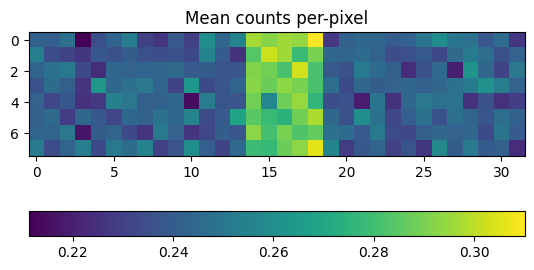

In [26]:
plt.imshow(res['means'].data)
plt.colorbar(orientation="horizontal")
plt.title('Mean counts per-pixel')

#### CuPy support

This UDF will also run on GPU through CuPy, on both `cupy` dense and `cupyx.scipy.sparse` arrays. The following section verifies if CuPy is available:

In [27]:
has_cupy = True
try:
    import cupy as cp
except ImportError:
    has_cupy = False
if has_cupy:
    from cupy_backends.cuda.api.runtime import CUDARuntimeError
    try:
        array = cp.zeros((1,))
    except CUDARuntimeError:
        has_cupy = False

We can again use the `MemoryDataSet` to perform on-the-fly conversion from the dense data we generated into a `cupyx.scipy.sparse.csr_matrix` format, to supply to our 'wide-support' UDF. To ensure that the computation actually happens on the GPU we create a LiberTEM context with one `CUDA` worker and zero cpu-workers.

The following cell will only run if CuPy is available:

In [28]:
if has_cupy:
    from libertem.executor.dask import DaskJobExecutor, cluster_spec
    ctx_cupy = lt.Context(
        # FIXME NEEDS TO BE SIMPLIFIED!!!
        DaskJobExecutor.make_local(
            cluster_spec(
                cpus=0,
                cudas=1,
                has_cupy=True
            )
        )
    )

In [29]:
# NBVAL_IGNORE_OUTPUT
if has_cupy:
    from sparseconverter import CUPY_SCIPY_CSR
    
    dataset_cupy_csr = ctx_cupy.load('memory', data=dense_data, array_backends=(CUPY_SCIPY_CSR,))
    print(f"RESULT => {ctx_cupy.run_udf(dataset_cupy_csr, MeanFrameUDF())['means'].data.sum()}")

With this particular CUDA-only `Context`, dense datasets will be automatically be moved to the GPU, as long as the UDF supports it (if not then this strange `Context` will raise an error):

In [30]:
# NBVAL_IGNORE_OUTPUT
if has_cupy:
    print(f"RESULT => {ctx_cupy.run_udf(dataset_dense, MeanFrameUDF())['means'].data.sum()} (on GPU)")

### Declaring Specific API compatibility

We can also rely on a specific library's API in our UDFs, by declaring compatibility with a subset of the available backends. For example a `scipy.sparse` matrix does not support the `np.where` function, which we could use for value thresholding:

In [31]:
import scipy.sparse
# raises ValueError
rand_data = np.random.randint(0, 5, size=(10, 10))
sparse_d = scipy.sparse.csr_matrix(rand_data)
try:
    np.where(sparse_d > 2, sparse_d, 0)
except ValueError as e:
    print(f'ValueError: {e}')

ValueError: setting an array element with a sequence.


However there is a sparse-supporting `where` function of `pydata.sparse`:

In [32]:
# NBVAL_IGNORE_OUTPUT
import sparse
sparse_d = sparse.GCXS.from_numpy(rand_data)
print(sparse.where(sparse_d > 2, sparse_d, 0))

<GCXS: shape=(10, 10), dtype=int64, nnz=34, fill_value=0, compressed_axes=(0,)>


The example is a bit contrived, but if we wanted to take advantage of `sparse.where` for processing sparse data, we can do this by declaring specific backends:

In [33]:
from libertem.udf.sum import SumUDF
from sparseconverter import SPARSE_COO, SPARSE_GCXS

class ThresholdSumSparse(SumUDF):
    """
    Sum the values of pixels with a value > threshold
    
    Uses sparse.where for thresholding, which is compatible
    with pydata.sparse arrays (declared in get_backends)
    """
    def __init__(self, threshold=0, dtype='float32'):
        UDF.__init__(self, threshold=threshold, dtype=dtype)
    
    def get_backends(self):
        # process_tile is compatible with pydata.sparse arrays only
        # it would be possible to adapt this UDF to also run on
        # dense numpy and cupy arrays via np.where (not done here)
        return (SPARSE_COO, SPARSE_GCXS,)
    
    def process_tile(self, tile):
        more_than_t = sparse.where(tile > self.params.threshold, tile, 0)
        sum_per_tile = more_than_t.sum(axis=0)
        
        self.results.intensity[:] += self.forbuf(
            sum_per_tile,
            self.results.intensity
        )

We can run this in parallel with the normal SumUDF maintaining the sparse-compatibility of ThresholdSumSparse. Firstly we run on the dense dataset (for example purposes):

In [34]:
threshold_level = 3
sum_results = ctx.run_udf(dataset_dense, udf=(SumUDF(), ThresholdSumSparse(threshold=threshold_level)))

We can see the difference in background noise level between the two UDFs:

Text(0.5, 0.98, 'Dense input data')

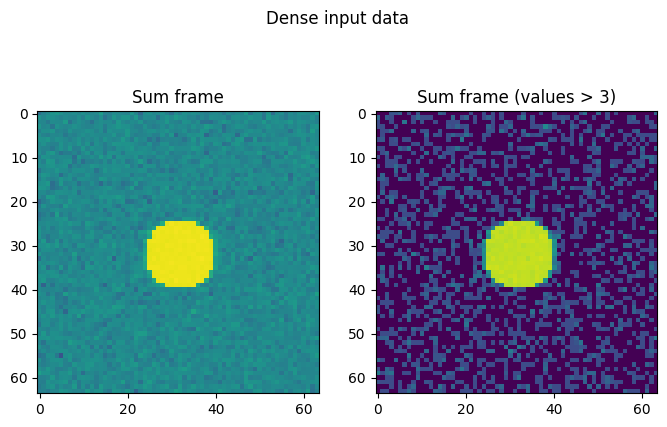

In [35]:
from matplotlib.colors import LogNorm
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 5))
ax0.imshow(sum_results[0]['intensity'].data + 1, norm=LogNorm(vmin=1, vmax=1000))
ax0.set_title('Sum frame')
ax1.imshow(sum_results[1]['intensity'].data + 1, norm=LogNorm(vmin=1, vmax=1000))
ax1.set_title(f'Sum frame (values > {threshold_level})')
fig.suptitle('Dense input data')

Even if we supply data in a different format, the UDF definition is used to convert to a compatible form. Here we use the on-disk raw CSR (`scipy`) data, and LiberTEM handles conversion to `sparse.GCXS` to take advantage of `sparse.where`:

In [36]:
sum_results_sparse = ctx.run_udf(dataset_csr, udf=(SumUDF(), ThresholdSumSparse(threshold=threshold_level)))

Text(0.5, 0.98, 'RawCSR input data')

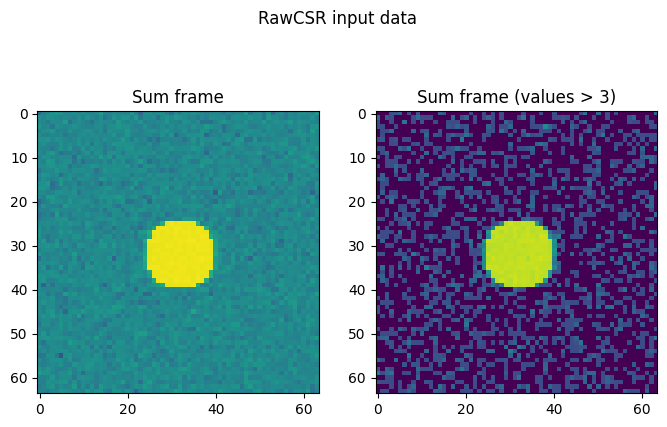

In [37]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 5))
ax0.imshow(sum_results[0]['intensity'].data + 1, norm=LogNorm(vmin=1, vmax=1000))
ax0.set_title('Sum frame')
ax1.imshow(sum_results[1]['intensity'].data + 1, norm=LogNorm(vmin=1, vmax=1000))
ax1.set_title(f'Sum frame (values > {threshold_level})')
fig.suptitle('RawCSR input data')

This is not the most efficient way to perform a threshold-sum, but demonstrates that UDFs can declare their compatibility explicitly and LiberTEM will handle conversion as appropriate.

## Dask and HyperSpy integration

In [38]:
from libertem.contrib.daskadapter import make_dask_array

### Dask array with sparse chunks

We explicitly request a sparse backend with ndarray support for the chunks by passing the `array_backend` parameter.
See https://docs.dask.org/en/stable/array-sparse.html for details on sparse Dask arrays!

In [39]:
sparse_dask_array, workers = make_dask_array(dataset_csr, array_backend=SPARSE_GCXS)

In [40]:
sparse_dask_array

dask.array<reshape, shape=(8, 32, 64, 64), dtype=float32, chunksize=(8, 32, 64, 64), chunktype=numpy.ndarray>

In [41]:
# NBVAL_IGNORE_OUTPUT
print(sparse_dask_array.sum().compute() / np.prod(sparse_dask_array.shape[2:]))

63.586669921875


### Dask array with dense CuPy chunks

We explicitly request the CUPY backend for the chunks by passing the `array_backend` parameter.
See https://docs.dask.org/en/stable/gpu.html for details on Dask arrays on GPUs!

In [42]:
# NBVAL_IGNORE_OUTPUT
if has_cupy:
    from sparseconverter import CUPY
    
    cupy_dask_array, workers = make_dask_array(dataset_csr, array_backend=CUPY)
    cupy_dask_array

In [43]:
# NBVAL_IGNORE_OUTPUT
if has_cupy:
    print(cupy_dask_array.sum().compute() / np.prod(cupy_dask_array.shape[2:]))

### Using pyxem on a sparse dataset

By default `make_dask_array()` will convert chunks to NumPy since that is expected by most downstream users, including pyxem and HyperSpy.

In [44]:
import pyxem

In [45]:
dense_dask_array, workers = make_dask_array(dataset_csr)
dense_4d = pyxem.signals.LazyDiffraction2D(dense_dask_array)

[########################################] | 100% Completed | 101.44 ms


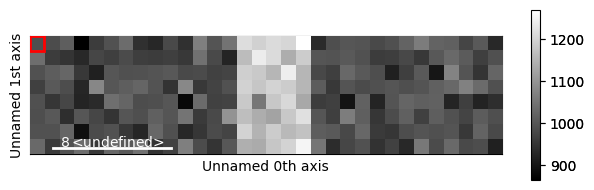

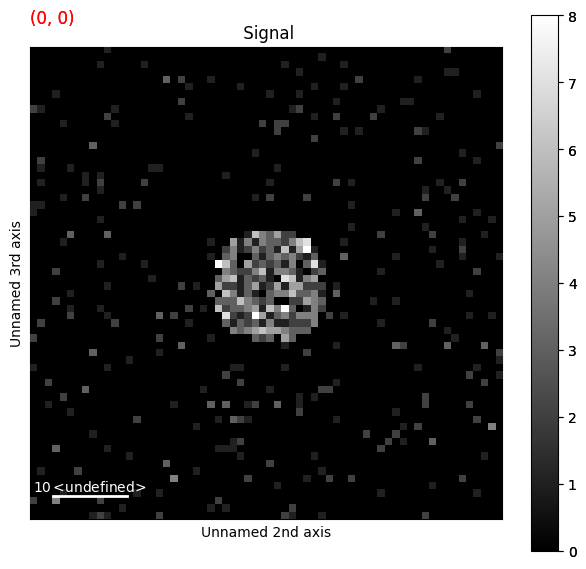

In [46]:
# NBVAL_IGNORE_OUTPUT
dense_4d.plot()